In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("cap5.csv")
df.head()

,cycle,ambient_temperature,datetime,capacity
0,1,24,2008-04-02 15:25:41,1.856487
1,2,24,2008-04-02 19:43:48,1.846327
2,3,24,2008-04-03 00:01:06,1.835349
3,4,24,2008-04-03 04:16:37,1.835263
4,5,24,2008-04-03 08:33:25,1.834646


In [3]:
df["datetime"] = pd.to_datetime(df["datetime"],format = "%Y-%m-%d %H:%M:%S")
df.drop(["cycle","ambient_temperature"],inplace=True,axis=1)
df.head()

,datetime,capacity
0,2008-04-02 15:25:41,1.856487
1,2008-04-02 19:43:48,1.846327
2,2008-04-03 00:01:06,1.835349
3,2008-04-03 04:16:37,1.835263
4,2008-04-03 08:33:25,1.834646


In [4]:
df["roll_2"] = df["capacity"].rolling(2).mean()
df["roll_3"] = df["capacity"].rolling(3).mean()
df["roll_4"] = df["capacity"].rolling(4).mean()
df["roll_5"] = df["capacity"].rolling(5).mean()
df["roll_7"] = df["capacity"].rolling(7).mean()
df["roll_10"] = df["capacity"].rolling(10).mean()
df.head()

,datetime,capacity,roll_2,roll_3,roll_4,roll_5,roll_7,roll_10
0,2008-04-02 15:25:41,1.856487,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-04-02 19:43:48,1.846327,1.851407,NaN,NaN,NaN,NaN,NaN
2,2008-04-03 00:01:06,1.835349,1.840838,1.846055,NaN,NaN,NaN,NaN
3,2008-04-03 04:16:37,1.835263,1.835306,1.838980,1.843357,NaN,NaN,NaN
4,2008-04-03 08:33:25,1.834646,1.834954,1.835086,1.837896,1.841614,NaN,NaN


In [5]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df["capacity"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.525685
p-value: 0.886906


C:\Users\mehme\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\mehme\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [6]:
from pmdarima.arima import auto_arima
def fun_arima(col):
    arima_model = auto_arima(df[col].dropna(), 
                               start_p=0, start_q=0,
                               test='adf',
                               max_p=2, max_q=2, m=12,
                               start_P=0, seasonal=True,
                               d=None, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    print(arima_model.summary())

In [90]:
#for col in df.columns[1:]:
fun_arima("roll_10")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-1274.239, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1243.305, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1378.976, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-1350.572, Time=0.35 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1358.629, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-1384.022, Time=0.30 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-1394.886, Time=1.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-1390.306, Time=0.30 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=-1376.829, Time=1.10 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-1391.496, Time=0.89 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-1259.955, Time=0.35 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=-1386.467, Time=0.87 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-1386.897, Time=0.57 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-1338.408, Time=0.81 sec
 ARIM

C:\Users\mehme\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:>

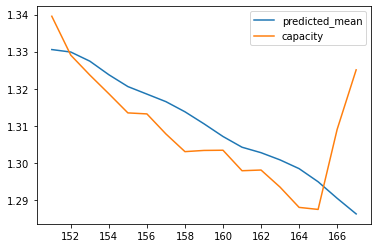

In [91]:
size = int(len(df) * 0.90)
X_train, X_test = df[0:size], df[size:len(df)]
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train['roll_10'],  
                order = (1,1,0),  
                seasonal_order =(2,1,1,12)) 
  
result = model.fit() 
result.summary() 
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

#Prediction
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index)
#Rename the column

# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['capacity'].plot(legend = True) 


In [92]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train["capacity"], train_prediction))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test["capacity"], prediction))
print('Test Score: %.5f RMSE' % (testScore))


Train Score: 0.48563 RMSE
Test Score: 0.01234 RMSE


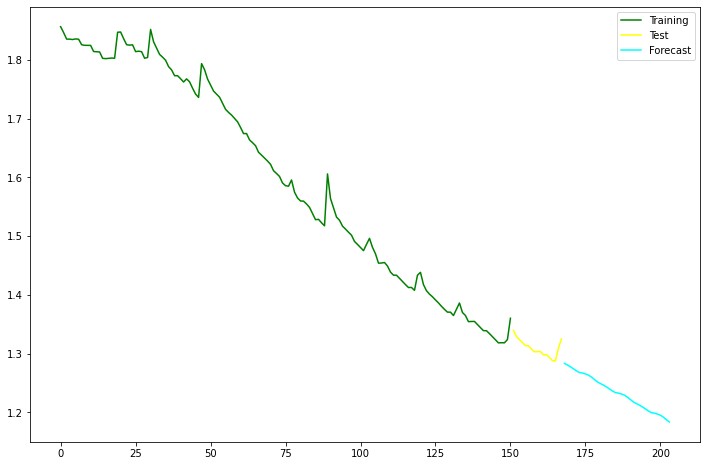

In [110]:
forecast = result.predict(start = len(df),  
                          end = (len(df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 
  
plt.figure(figsize=(12,8))
plt.plot(X_train["capacity"], label='Training', color='green')
plt.plot(X_test["capacity"], label='Test', color='yellow')

plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='upper right')
plt.show()

In [93]:
dic[10] = testScore

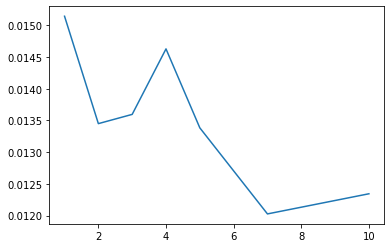

In [109]:
names = list(dic.keys())
values = list(dic.values())
plt.plot(names,values)
plt.show()